Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 0.01444


<Figure size 864x432 with 0 Axes>

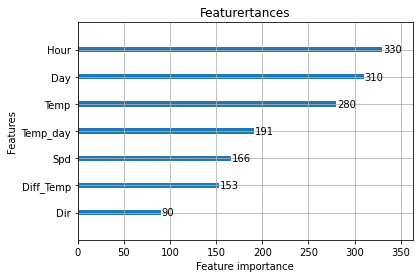

In [57]:
# Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

Mode = 'Train'

sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")

point = 600

if Mode == 'Train':
    train_data = sunshine[0:-point].merge(temp, on=['Day', 'Hour'], how='left')
    val_data = sunshine[4500-point:].merge(temp, on=['Day', 'Hour'], how='left')
    pre_data = val_data.copy()

elif Mode == 'Pred':
    train_data = sunshine[0:-point].merge(temp, on=['Day', 'Hour'], how='left')
    val_data = sunshine[4500-point:].merge(temp, on=['Day', 'Hour'], how='left')
    sunshine1 = sunshine.iloc[0:150, :]
    sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)
    pre_data = sunshine1.merge(temp, on=['Day', 'Hour'], how='left')

train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')
Temp_day = train_data.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
train_data = train_data.merge(Temp_day, on=['Day'], how='left')

val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')
Temp_day = val_data.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
val_data = val_data.merge(Temp_day, on=['Day'], how='left')

pre_data = pre_data.merge(wind, on=['Day', 'Hour'], how='left')
Temp_day = pre_data.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
pre_data = pre_data.merge(Temp_day, on=['Day'], how='left')

features = [f for f in train_data.columns if f not in ['Radiation', 'day_t']]
X_train, X_test, Y_train, Y_test = train_test_split(train_data[features], train_data['Radiation'].values, test_size=0.1, random_state=42)

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression_l2',
    'num_leaves': 20,
    'learning_rate': 0.1,
    'metric': {'mse'},
    'verbose': -1,
    'min_data_in_leaf': 4,
    'max_depth':7,
    'seed':42
}

lgb_train = lgb.Dataset(train_data[features], train_data['Radiation'].values)
lgb_eval = lgb.Dataset(val_data[features], val_data['Radiation'].values, reference=lgb_train)

# train
gbm = lgb.train(params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=30)])

# 预测提交数据
Y_pred = gbm.predict(pre_data[features])

plt.figure(figsize=(12, 6))
lgb.plot_importance(gbm, max_num_features=20)
plt.title("Featurertances")
plt.show()

0.014439982563124735

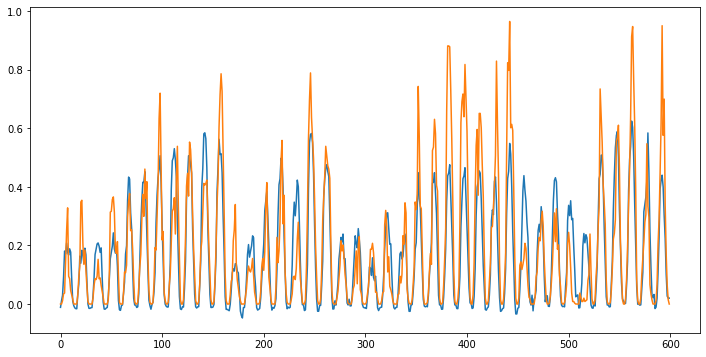

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(Y_pred)
plt.plot(pre_data['Radiation'])
# plt.plot(val_data['Temp'])
# plt.plot(val_data['Spd'])
# plt.plot(val_data['Dir'])

from sklearn.metrics import mean_squared_error
mean_squared_error(pre_data['Radiation'], Y_pred)

In [59]:
dataframe = pd.DataFrame({'Radiation': Y_pred})
dataframe.to_csv("Dataset/Y_pred.csv", index=False, sep=',')